In [30]:
from pathlib import Path
import time
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from shapely.ops import MultiLineString
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from bikewaysim.paths import config
from bikewaysim.impedance_calibration import summarize_route, stochastic_optimization, post_calibration
from bikewaysim.routing import rustworkx_routing_funcs

In [31]:
links, turns_df, length_dict, geo_dict, turn_G = rustworkx_routing_funcs.import_calibration_network(config)

# just make this a function
with (config['calibration_fp']/'ready_for_calibration.pkl').open('rb') as fh:
    ready_for_calibration = pickle.load(fh)
print(len(ready_for_calibration),'trips')

# get the best performing full model so far
best_model = 'bootstrap_final,validation,0'
with (config['calibration_fp']/f'loss/{best_model}.pkl').open('rb') as fh:
    best_model = pickle.load(fh)

# reduce size ofready for calibration
ready_for_calibration = {key:item for key,item in ready_for_calibration.items() if key in best_model.keys()}
print(len(ready_for_calibration),'trips')

2577 trips
664 trips


In [32]:
full_model = (
    {'col':'2lpd','type':'link','range':[0,1]},
    {'col':'3+lpd','type':'link','range':[0,1]},
    {'col':'(30,inf) mph','type':'link','range':[0,1]},
    {'col':'[4k,10k) aadt','type':'link','range':[0,1]},
    {'col':'[10k,inf) aadt','type':'link','range':[0,1]},
    {'col':'[4,6) grade','type':'link','range':[0,3]},
    {'col':'[6,inf) grade','type':'link','range':[0,3]},
    {'col':'bike lane','type':'link','range':[-1,0]},
    {'col':'cycletrack','type':'link','range':[-1,0]},
    {'col':'multi use path','type':'link','range':[-1,0]},
    {'col':'unsig_crossing','type':'turn','range':[0,2]},
    )
corr_names = [x['col'] for x in full_model]
corr_names.remove('unsig_crossing')

In [33]:
correlation_matrix = links[corr_names].corr().round(2)

In [34]:
rename = ['2 Lanes Per Dir.','3+ Lanes Per Dir.','30+ MPH','[4k, 10k) AADT','[10k, inf) AADT','[4%, 6%) grade','[6%, inf)', 'Bike Lane', 'Cycletrack', 'Multi-Use Path']
correlation_matrix.columns = rename
correlation_matrix.index = rename

In [35]:
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False, False, False,
         True]])

In [45]:
mask = np.array([
    [False,  True,  True,  True,  True,  True,  True,  True,  True, True],
    [False,  False,  True,  True,  True,  True,  True,  True,  True, True],
    [False, False,  False,  True,  True,  True,  True,  True,  True, True],
    [False, False, False,  False,  True,  True,  True,  True,  True, True],
    [False, False, False, False,  False,  True,  True,  True,  True, True],
    [False, False, False, False, False,  False,  True,  True,  True, True],
    [False, False, False, False, False, False,  False,  True,  True, True],
    [False, False, False, False, False, False, False,  False,  True, True],
    [False, False, False, False, False, False, False, False,  False, True],
    [False, False, False, False, False, False, False, False, False, False]
    ])

Correlation Matrix:
                   2 Lanes Per Dir.  3+ Lanes Per Dir.  30+ MPH  \
2 Lanes Per Dir.               1.00              -0.06     0.45   
3+ Lanes Per Dir.             -0.06               1.00     0.23   
30+ MPH                        0.45               0.23     1.00   
[4k, 10k) AADT                 0.08               0.02     0.28   
[10k, inf) AADT                0.51               0.29     0.53   
[4%, 6%) grade                -0.02              -0.01    -0.02   
[6%, inf)                     -0.07              -0.03    -0.09   
Bike Lane                      0.00               0.03     0.10   
Cycletrack                    -0.01              -0.01    -0.02   
Multi-Use Path                -0.05              -0.03    -0.07   

                   [4k, 10k) AADT  [10k, inf) AADT  [4%, 6%) grade  [6%, inf)  \
2 Lanes Per Dir.             0.08             0.51           -0.02      -0.07   
3+ Lanes Per Dir.            0.02             0.29           -0.01      -0.03   

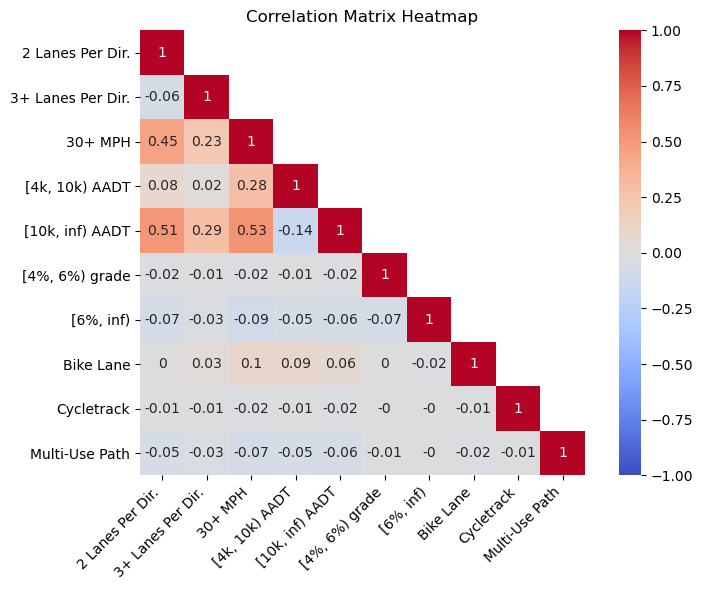

In [48]:
import seaborn as sns

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix using seaborn heatmap
# fig, ax = plt.subplots(figsize=(8,6))

plt.figure(figsize=(8, 6))
my_plot = sns.heatmap(correlation_matrix, annot=True, square=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)

#rotate x-axis labels
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.savefig(config['figures_fp']/'network_corr.png',dpi=300)
plt.show()

In [ ]:


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [21]:
links[corr_names].iloc[:,[0,1]].value_counts()

2lpd  3+lpd
0     0        130739
1     0         17866
0     1          4612
dtype: int64